# Genetic Algorithms Lab

This notebook contains the work done by **Valentin Ringlet (i6191244)** and **Nick Oikonomou (i6201767)**.

- First, we'll define a generic genetic algorithm framework.

- Second, we'll implement the knapsack problem for the genetic algorithm framework.

- Third, we'll implement the travelling salesman problem (TSP) for the genetic algorithm framework.

In [1]:
# Import any needed libraries
import numpy as np
import matplotlib.pyplot as plt
import random

## Generic genetic algorithm framework

We will first implement the generic genetic algorithm framework.
To make it as customisable as possible, the generic genetic algorithm functions rely on functions provided as parameters to the functions.
The following subsections will provide first the generic genetic algorithm function that calls the generic functions for:
- selection of individuals to keep in the next generation

- crossover of individuals to generate new children

- mutation of individuals (with a certain probability)

In [2]:
def generic_genetic_algo(starting_population, number_iterations,
                         selection_population_size, select_individual_for_next_generation_fct,        # for selection function
                         select_individual_for_reproduction_fct, crossover_fct,                       # for crossover function
                         mutation_proba, apply_mutation_fct,                                          # for mutation function
                         print_stats = False
                        ):
    ''' Use the functions defined above for selection, crossover, mutation to run a genetic algorithm on the given population
    
        params:
            TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO
    '''
    # Save the size of the population
    pop_size = len(starting_population)
    
    # Then repeat creating a new population
    generation_num = 1
    previous_population = starting_population
    
    # Append the lists of fitnesses of all the individuals at each generation
    full_fitnesses = []
    
    # Initialize the figure to a None value
    
    ''' TO SEE: do we want to do a more complex monitoring of the fitness function, then stop once the fitness values of the population aren't evolving anymore '''
    while generation_num <= number_iterations:
        # First, select individuals from the previous generation to create a mating pool for this generation
        population = selection(previous_population,
                               selection_population_size,
                               select_individual_for_next_generation_fct)
        
        # Then, restore a full population by doing crossover
        population = crossover(population,
                               pop_size,
                               select_individual_for_reproduction_fct,
                               crossover_fct)
        
        # Finally, apply mutations on the population
        population = mutation(population,
                              mutation_proba,
                              apply_mutation_fct)
        
        fitnesses_i = [ind.get_fitness() for ind in population]
        
        full_fitnesses.append(fitnesses_i)
        
        if print_stats:
            print(f'\nGeneration #{generation_num}')
            print(f'Min fitness: {np.min(fitnesses_i)}')
            print(f'Average fitness: {np.mean(fitnesses_i)}')
            print(f'Max fitness: {np.max(fitnesses_i)}')
        
        # Finally, move to the next generation and save the current population as the previous generation's population
        generation_num += 1
        previous_population = population
    
    # TEST TEST TEST TEST HISTOGRAM TEST
    plt.ion()
    plt.hist()
    
    
    return population[fitnesses_i.index(np.max(fitnesses_i))], full_fitnesses

### Selection

In this section, we will define the function used for the selection of individuals from one generation to keep in the next generation.

In [3]:
def selection(population, num_selected_individuals, select_individual_fct):
    ''' Make a selection of individuals from the given population for the next generation.
    
        params:
            population: the previous population, from which we choose individuals
            num_selected_individuals: the number of individuals to select from the population
            select_individual_fct: the function that is used to select an individual to keep in the next generation
        
        return:
            a new population, with individuals picked from the input population,
                by using the provided function to select the individuals
    '''
    selected_list = []
    for i in range(num_selected_individuals):
        ind = select_individual_fct(population)
        while ind in selected_list:
            ind = select_individual_fct(population)
        selected_list.append(ind)
    return selected_list

### Crossover

In this section, we will define the function used for the crossover of individuals from a certain population to create children.

In [58]:
def crossover(population, final_size_population, select_parent_fct, crossover_single_fct):
    ''' Make the given population have new children by crossover.
    
        params:
            population: the individuals we start with
            final_size_population: the size we want the resulting population to be
            select_parent_fct: the function that can be used to get the individual parents
            crossover_single_fct: the function that is used to generate a child by crossover of two parents
        
        return:
            the population, with the addition of new children, to have "final_size_population" individuals in total.
                parents are selected by using the provided select_parent_fct function, and 
                the crossover is performed by using the crossover_single_fct
    '''
    start_size_population = len(population)
    
    ############################### NOT SURE IF THAT IS NECESSARY ########################################
    assert start_size_population <= final_size_population, "The population needs to be smaller than it should be after crossover"
    
    
    children = []
    for i in range(final_size_population - start_size_population):
        # Select 2 random individuals from the population
        parent1 = select_parent_fct(population)
        parent2 = select_parent_fct(population)
        # Make sure that they are different
        while (parent1 == parent2):
            parent2 = select_parent_fct(population)
        
        # Use the crossover_single function to create a new child
        child_phenotype = crossover_single_fct(parent1, parent2)
        
        child = type(parent2)(parent2.get_problem(), child_phenotype)
        
        # And add it to the population
        children.append(child)
    
    # Finally, the new population is a list with the individuals from the starting population plus the children that were generated
    return population + children

### Mutation

In this section, we will define the function used for the mutation of individuals from a given population (with a certain mutation probability).

In [59]:
def mutation(population, mutation_proba, apply_mutation_fct):
    ''' Apply mutations to some individuals from the population
    
        params:
            population: the starting population
            mutation_proba: the probability of having a mutation in a certain individual 
                It should be a real value between 0 and 1.
            apply_mutation_fct: the function used for computing the mutated phenotype based on the provided phenotype
        
        return:
            the same population, except that some individuals might have been mutated
    '''
    # For each individual
    for i in range(len(population)):
        mutate_choice = np.random.rand()
        
        # if the random number is smaller than the probability of mutation 
        if mutate_choice <= mutation_proba:
            # We apply a mutation to that individual
            #   1. get the original phenotype of the individual
            old_phenotype = population[i].get_phenotype()
            
            #   2. compute the mutated phenotype
            mutated_phenotype = apply_mutation_fct(old_phenotype, population[i].get_possible_values())
            
            #   3. replace the old individual by the new one
            population[i] = type(population[i])(population[i].get_problem(), mutated_phenotype)
    
    return population

## Specific methods for performing selection, crossover, mutation

In this section, a number of specific functions will be defined for performing the selection, crossover or mutation steps of the generic genetic algorithm framework above.

The following aspects have functions defined for them:
- Selecting an individual from a given population:

    This can be used in the **selection** step, for selecting individuals from one generation to keep in the next.
    
    But it can also be used in the **crossover** step, for selecting individuals as parents to reproduce.
    
    The following methods are available as of now:
    - select_individual_uniform_proba
    - select_individual_roulette_wheel
    
- Performing a crossover based on two individuals provided as parents:

    This is used only in the **crossover** step, to actually perform the crossover.
    
    The following methods are available as of now:
    - crossover_single_uniform_proba

- Performing a mutation, given a individual to mutate:

    This is used in the **mutation** step only, to perform the mutation.
    
    The following methods are available as of now:
    - apply_mutation_uniform_proba

In [60]:
def select_individual_uniform_proba(population):
    ''' Choose and return an individual from the given population.
        The individual is chosen using uniform probability
    
        params: 
            population: the population of individuals to chose an individual from
        
        return:
            an individual chosen from the given population
    '''
    return np.random.choice(population)

def select_individual_roulette_wheel(population):
    ''' Choose and return an individual from the given population.
        The individual is chosen using the roulette wheel selection approach
    
        params: 
            population: the population of individuals to chose an individual from
        
        return:
            an individual chosen from the given population
    '''
    #Fitness scores
    fitness_scores = [individual.get_fitness() for individual in population]
    #Total sum of fitness scores
    sum_fitness_scores =  sum([individual.get_fitness() for individual in population])
    #Create distribution
    dist = fitness_scores / sum_fitness_scores
    
    return np.random.choice(population, p = dist)


def crossover_single_uniform_crossover(parent1, parent2, crossover_proba=0.5):
    ''' Create a new child using parents individual1 and individual2.
        This version of crossover_single() uses uniform crossover.
    
        params:
            parent1: one parent of the new child
            parent2: the other parent of the new child
            crossover_proba: the probability of swapping an element of parent1 with an element of parent2 
        
        return:
            a new individual
    '''
    # Retrieve the phenotypes of the two parents
    phenotype1 = parent1.get_phenotype()
    phenotype2 = parent2.get_phenotype()
    
    # Perform the uniform crossover
    for i in range(len(phenotype1)):
        random_num = np.random.rand()
        
        # If the random number is larger than a certain probability (50 %) then we swap the values
        if random_num <= crossover_proba:
            # Swap the values at that index
            temp = phenotype1[i]
            phenotype1[i] = phenotype2[i]
            phenotype2[i] = temp
    
    # Finally, return the modified phenotype1
    return phenotype1

def apply_mutation_uniform_proba(phenotype, possible_replacement_values):
    ''' Apply a mutation on the given phenotype.
        Each index has an uniform probability of being selected, and every possible replacement value is equally likely.
        
        params:
            phenotype: the list that will be mutated
    '''
    mutation_index = np.random.randint(len(phenotype))
    
    mutation_value = np.random.choice(possible_replacement_values)
    
    phenotype[mutation_index] = mutation_value
    
    return phenotype

In [81]:
############### TALK WITH VALENTIN ABOUT THIS ################

def crossover_individual_TSP(parent1, parent2):
    '''
    Given two parents, the method creates a valid TSP child. This version chooses a part of parent 1
    to be moved. The moved nodes are also removed from parent2, then randomised and appended at the end of the parent2.
    
    params: 
        parent1: first parent
        parent2: second parent
    '''
    #Get phenotypes of parents 
    phenotype1 = parent1.get_phenotype()
    phenotype2 = parent2.get_phenotype()
    
    #Generate random number for split
    num = np.random.randint(len(phenotype1))
    
    to_be_moved = phenotype1[num:]
    
    for item in to_be_moved:
        phenotype2.remove(item)
    
    to_be_moved_randomised =  random.sample(list(to_be_moved), len(to_be_moved))
    
    child_pheno =  phenotype2 + to_be_moved_randomised
    return child_pheno


def apply_mutation_swap(phenotype, possible_replacement_values):
    ''' Apply a mutation on the given phenotype.
        This function is specifically designed for the TSP problem
        
        params:
            phenotype: the list that will be mutated
    '''
    # Select 2 indexes
    index1 = np.random.randint(len(phenotype))
    index2 = np.random.randint(len(phenotype))
    
    # Swap the 2 values
    temp = phenotype[index1]
    phenotype[index1] = phenotype[index2]
    phenotype[index2] = temp
    
    # Return the changed phenotype
    return phenotype

### Knapsack problem implementation

In [62]:
class KnapsackProblem:
    def __init__(self,n, maximum_weight):
        ''' Initialize any needed variables
        
            params:
                n: number of items for the knapsack problem 
                maximum_weight: maximum weight that the bag contains
        '''
        #Initiliase maximum allowed weight
        self.maximum_weight = maximum_weight
        #Initialise items
        self.n = n
        #Initialise weights
        self.weights = []
        for i in range(self.n):
            self.weights.append(np.random.choice(np.arange(10)+1))
        #Initialise rewards
        self.rewards = np.arange(self.n) + 1   
    
    #Return rewards
    def get_rewards(self):
        return self.rewards
    
    #Return Weights
    def get_weights(self):
        return self.weights

In [63]:
class KnapsackIndividual:
    # The possible values a single index of the phenotype can take
    list_possible_values = ['0', '1']
    
    def __init__(self, knapsackproblem, phenotype = None):            # if needed, add more parameters
        ''' Initialize any needed variables
        
            params:
                phenotype: a phenotype value that we want to set the individual to
                knapsackproblem: The knapsack problem that the individual exists
        '''
        #Initialise problem
        self.knapsackproblem = knapsackproblem
        
        if phenotype ==  None:
            #Create and initialise genotype randomly
            self.genotype = ""
            for i in range(knapsackproblem.n):
                self.genotype += str(np.random.choice(np.arange(2)))
        else:
            # Create and initialise the genotype based on the given phenotype
            self.genotype = "".join(phenotype)
        
    def get_phenotype(self):
        ''' Return the phenotype of this individual as a list type object
        '''
        return [char for char in self.genotype]
    
    def get_weight(self):
        ''' Return the total weight of this solution '''
        #Find the total weight of the individual 
        phenotype = self.get_phenotype()
        
        total_individual_weight = 0
        for i in range(len(phenotype)):
            if(phenotype[i] == "1"):
                total_individual_weight += (self.knapsackproblem.get_weights()[i])
        
        return total_individual_weight
    
    def is_legal(self):
        ''' Return the legality of the individual(weight)
        '''
        #Find the total weight of the individual 
        phenotype = self.get_phenotype()
        #Keep track of the total weight and total reward of the individual
        total_individual_weight = self.get_weight()
        
        #Check for legality
        if total_individual_weight > (self.knapsackproblem.maximum_weight):
            return False;
        else:
            return True;
    
    def get_reward(self):
        ''' Return the total reward of this individual
        '''
        #Find the total weight of the individual 
        phenotype = self.get_phenotype()
        #Total reward
        total_individual_reward = 0
        for i in range(len(phenotype)):
            if(phenotype[i] == "1"):
                total_individual_reward += (self.knapsackproblem.get_rewards()[i])
        return total_individual_reward
        
    def get_fitness(self):
        ''' Return the fitness score of this individual as a float
        '''
        if self.is_legal() == False:
            return 0;
        else:
            return self.get_reward();
    
    
    def get_possible_values(self):
        ''' Return a list of the possible values a single index of the phenotype can take.
        '''
        return self.list_possible_values
    
    def get_problem(self):
        return self.knapsackproblem

In [64]:
population = []
population_size = 100 # POPULATION SIZE CAN BE CHANGED HERE

problem = KnapsackProblem(10, 40)
for i in range(population_size):
    population.append(KnapsackIndividual(problem))


    
num_generation_runs = 1000
selection_population_size = 20
select_individual_for_next_generation_fct = select_individual_roulette_wheel
select_individual_for_reproduction_fct = select_individual_uniform_proba
crossover_fct = crossover_single_uniform_crossover
mutation_proba = 0.05
apply_mutation_fct = apply_mutation_swap

print_fitnesses = True
best_individual, stats_Knapsack = generic_genetic_algo(population, num_generation_runs,
                                              selection_population_size, select_individual_for_next_generation_fct,        # for selection function
                                              select_individual_for_reproduction_fct, crossover_fct,                       # for crossover function
                                              mutation_proba, apply_mutation_fct,                                          # for mutation function
                                              print_fitnesses
                                              )


print(f'\nTop performing individual: \nFitness score: {best_individual.get_fitness()}\nWeight: {best_individual.get_phenotype()}')

print(f'Problem: \nWeights are {problem.get_weights()}\nRewards are {problem.get_rewards()}')



# Make some plots with the list of fitnesses of all individuals over all generations ?
# --> could use "stats" for that


Generation #1
Min fitness: 0
Average fitness: 28.94
Max fitness: 50

Generation #2
Min fitness: 0
Average fitness: 34.21
Max fitness: 50

Generation #3
Min fitness: 0
Average fitness: 36.42
Max fitness: 50

Generation #4
Min fitness: 0
Average fitness: 38.05
Max fitness: 50

Generation #5
Min fitness: 0
Average fitness: 42.08
Max fitness: 50

Generation #6
Min fitness: 0
Average fitness: 42.68
Max fitness: 50

Generation #7
Min fitness: 25
Average fitness: 44.27
Max fitness: 50

Generation #8
Min fitness: 25
Average fitness: 42.17
Max fitness: 50

Generation #9
Min fitness: 0
Average fitness: 42.34
Max fitness: 50

Generation #10
Min fitness: 0
Average fitness: 45.92
Max fitness: 50

Generation #11
Min fitness: 33
Average fitness: 45.62
Max fitness: 50

Generation #12
Min fitness: 0
Average fitness: 45.73
Max fitness: 50

Generation #13
Min fitness: 0
Average fitness: 46.39
Max fitness: 50

Generation #14
Min fitness: 0
Average fitness: 45.25
Max fitness: 50

Generation #15
Min fitnes


Generation #119
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #120
Min fitness: 0
Average fitness: 49.38
Max fitness: 50

Generation #121
Min fitness: 44
Average fitness: 49.83
Max fitness: 50

Generation #122
Min fitness: 0
Average fitness: 49.16
Max fitness: 50

Generation #123
Min fitness: 0
Average fitness: 47.68
Max fitness: 50

Generation #124
Min fitness: 35
Average fitness: 49.45
Max fitness: 50

Generation #125
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #126
Min fitness: 0
Average fitness: 49.42
Max fitness: 50

Generation #127
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Generation #128
Min fitness: 45
Average fitness: 49.95
Max fitness: 50

Generation #129
Min fitness: 44
Average fitness: 49.94
Max fitness: 50

Generation #130
Min fitness: 44
Average fitness: 49.94
Max fitness: 50

Generation #131
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #132
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Ge


Generation #238
Min fitness: 45
Average fitness: 49.95
Max fitness: 50

Generation #239
Min fitness: 0
Average fitness: 49.38
Max fitness: 50

Generation #240
Min fitness: 0
Average fitness: 46.98
Max fitness: 50

Generation #241
Min fitness: 0
Average fitness: 48.86
Max fitness: 50

Generation #242
Min fitness: 0
Average fitness: 49.0
Max fitness: 50

Generation #243
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #244
Min fitness: 41
Average fitness: 49.91
Max fitness: 50

Generation #245
Min fitness: 46
Average fitness: 49.96
Max fitness: 50

Generation #246
Min fitness: 0
Average fitness: 48.43
Max fitness: 50

Generation #247
Min fitness: 0
Average fitness: 49.0
Max fitness: 50

Generation #248
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #249
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #250
Min fitness: 0
Average fitness: 48.28
Max fitness: 50

Generation #251
Min fitness: 0
Average fitness: 49.44
Max fitness: 50

Gene

Generation #357
Min fitness: 0
Average fitness: 49.17
Max fitness: 50

Generation #358
Min fitness: 0
Average fitness: 48.93
Max fitness: 50

Generation #359
Min fitness: 42
Average fitness: 49.82
Max fitness: 50

Generation #360
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #361
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #362
Min fitness: 47
Average fitness: 49.97
Max fitness: 50

Generation #363
Min fitness: 44
Average fitness: 49.94
Max fitness: 50

Generation #364
Min fitness: 0
Average fitness: 49.39
Max fitness: 50

Generation #365
Min fitness: 0
Average fitness: 48.92
Max fitness: 50

Generation #366
Min fitness: 0
Average fitness: 49.38
Max fitness: 50

Generation #367
Min fitness: 0
Average fitness: 47.14
Max fitness: 50

Generation #368
Min fitness: 0
Average fitness: 47.13
Max fitness: 50

Generation #369
Min fitness: 0
Average fitness: 49.41
Max fitness: 50

Generation #370
Min fitness: 41
Average fitness: 49.91
Max fitness: 50

Ge


Generation #476
Min fitness: 41
Average fitness: 49.85
Max fitness: 50

Generation #477
Min fitness: 0
Average fitness: 49.37
Max fitness: 50

Generation #478
Min fitness: 44
Average fitness: 49.94
Max fitness: 50

Generation #479
Min fitness: 42
Average fitness: 49.92
Max fitness: 50

Generation #480
Min fitness: 0
Average fitness: 49.0
Max fitness: 50

Generation #481
Min fitness: 44
Average fitness: 49.94
Max fitness: 50

Generation #482
Min fitness: 46
Average fitness: 49.96
Max fitness: 50

Generation #483
Min fitness: 0
Average fitness: 47.92
Max fitness: 50

Generation #484
Min fitness: 46
Average fitness: 49.96
Max fitness: 50

Generation #485
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Generation #486
Min fitness: 44
Average fitness: 49.94
Max fitness: 50

Generation #487
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #488
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #489
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

G


Generation #592
Min fitness: 0
Average fitness: 48.66
Max fitness: 50

Generation #593
Min fitness: 0
Average fitness: 47.45
Max fitness: 50

Generation #594
Min fitness: 0
Average fitness: 45.57
Max fitness: 50

Generation #595
Min fitness: 0
Average fitness: 48.22
Max fitness: 50

Generation #596
Min fitness: 0
Average fitness: 46.81
Max fitness: 50

Generation #597
Min fitness: 0
Average fitness: 47.49
Max fitness: 50

Generation #598
Min fitness: 38
Average fitness: 49.46
Max fitness: 50

Generation #599
Min fitness: 0
Average fitness: 48.72
Max fitness: 50

Generation #600
Min fitness: 45
Average fitness: 49.92
Max fitness: 50

Generation #601
Min fitness: 0
Average fitness: 45.13
Max fitness: 50

Generation #602
Min fitness: 0
Average fitness: 48.86
Max fitness: 50

Generation #603
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #604
Min fitness: 45
Average fitness: 49.95
Max fitness: 50

Generation #605
Min fitness: 0
Average fitness: 48.94
Max fitness: 50

Ge


Generation #708
Min fitness: 0
Average fitness: 46.19
Max fitness: 50

Generation #709
Min fitness: 42
Average fitness: 48.8
Max fitness: 50

Generation #710
Min fitness: 42
Average fitness: 49.41
Max fitness: 50

Generation #711
Min fitness: 0
Average fitness: 48.65
Max fitness: 50

Generation #712
Min fitness: 0
Average fitness: 47.74
Max fitness: 50

Generation #713
Min fitness: 0
Average fitness: 49.26
Max fitness: 50

Generation #714
Min fitness: 42
Average fitness: 49.26
Max fitness: 50

Generation #715
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #716
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Generation #717
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #718
Min fitness: 43
Average fitness: 49.93
Max fitness: 50

Generation #719
Min fitness: 0
Average fitness: 49.0
Max fitness: 50

Generation #720
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #721
Min fitness: 46
Average fitness: 49.9
Max fitness: 50

Gene


Generation #824
Min fitness: 41
Average fitness: 49.91
Max fitness: 50

Generation #825
Min fitness: 0
Average fitness: 47.94
Max fitness: 50

Generation #826
Min fitness: 0
Average fitness: 45.0
Max fitness: 50

Generation #827
Min fitness: 0
Average fitness: 45.28
Max fitness: 50

Generation #828
Min fitness: 0
Average fitness: 43.26
Max fitness: 50

Generation #829
Min fitness: 0
Average fitness: 48.52
Max fitness: 50

Generation #830
Min fitness: 0
Average fitness: 49.04
Max fitness: 50

Generation #831
Min fitness: 0
Average fitness: 48.6
Max fitness: 50

Generation #832
Min fitness: 0
Average fitness: 46.84
Max fitness: 50

Generation #833
Min fitness: 0
Average fitness: 48.5
Max fitness: 50

Generation #834
Min fitness: 43
Average fitness: 49.93
Max fitness: 50

Generation #835
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Generation #836
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #837
Min fitness: 0
Average fitness: 49.0
Max fitness: 50

Generati


Generation #943
Min fitness: 0
Average fitness: 46.88
Max fitness: 50

Generation #944
Min fitness: 0
Average fitness: 45.13
Max fitness: 50

Generation #945
Min fitness: 0
Average fitness: 47.73
Max fitness: 50

Generation #946
Min fitness: 0
Average fitness: 48.08
Max fitness: 50

Generation #947
Min fitness: 0
Average fitness: 45.68
Max fitness: 50

Generation #948
Min fitness: 0
Average fitness: 47.56
Max fitness: 50

Generation #949
Min fitness: 0
Average fitness: 45.7
Max fitness: 50

Generation #950
Min fitness: 0
Average fitness: 48.34
Max fitness: 50

Generation #951
Min fitness: 40
Average fitness: 49.18
Max fitness: 50

Generation #952
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #953
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Generation #954
Min fitness: 0
Average fitness: 49.5
Max fitness: 50

Generation #955
Min fitness: 50
Average fitness: 50.0
Max fitness: 50

Generation #956
Min fitness: 0
Average fitness: 49.34
Max fitness: 50

Generat

In [11]:
best_individual.get_weight()
np.sum([3, 4, 5, 6, 7, 8, 9, 10])

52

In [12]:
fitness_scores = []
for individual in population:
    fitness_scores.append(individual.get_fitness())

(array([ 5.,  3.,  5.,  8., 20., 19., 17., 12.,  9.,  2.]),
 array([ 0. ,  4.9,  9.8, 14.7, 19.6, 24.5, 29.4, 34.3, 39.2, 44.1, 49. ]),
 <a list of 10 Patch objects>)

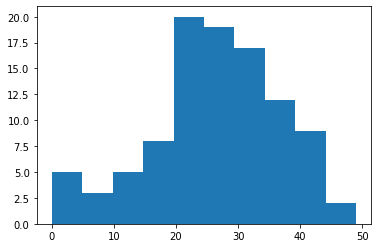

In [13]:
plt.hist(fitness_scores)

### Travelling salesman problem

In [14]:
class TSPProblem:
    def __init__(self, number_of_cities):
        '''Initiliaze the variables for the problem
        
            params:
                number_of_cities: define the number of cities in the problem
        '''
        #Initialise number of cities in the graph 
        self.number_of_cities = number_of_cities
        
        #Initialise nodes 
        self.nodes = np.arange(number_of_cities)
        
        #Define the representation
        self.representation = - np.ones((self.number_of_cities, self.number_of_cities));
        for i in range(number_of_cities):
            for j in range(number_of_cities):
                if i == j:
                    self.representation[i][j] = 0
                elif self.representation[j][i] != -1:
                    # Copy the value to have a symmetric matrix (as distance(0, 1) should be the same as distance(1, 0))
                    self.representation[i][j] = self.representation[j][i]
                else:
                    distance = np.random.choice(np.arange(10) + 1)
                    self.representation[i][j] = distance
        
    def get_representation(self):
        return self.representation
    
    def get_nodes(self):
        return self.nodes
    
    def get_distance(self,node1,node2):
        return self.representation[node1][node2]

In [15]:
############## TEST TEST TEST #################
TSPproblem1 = TSPProblem(5)
print(TSPproblem1.get_representation())
print(TSPproblem1.get_nodes())
print(TSPproblem1.get_distance(0,4))

[[ 0. 10.  1.  1.  7.]
 [10.  0.  9.  1.  3.]
 [ 1.  9.  0.  9.  1.]
 [ 1.  1.  9.  0.  9.]
 [ 7.  3.  1.  9.  0.]]
[0 1 2 3 4]
7.0


In [16]:
class TSPIndividual:
    
    def __init__(self, tspproblem, phenotype=None):  # if needed, add more parameters
        ''' Initialize any needed variables
        
            params:
                tspproblem: a phenotype value that we want to set the individual to
        '''
        #Initialise the problem that we are working on
        self.tspproblem = tspproblem
        
        #List of possible values
        self.list_possible_values = self.tspproblem.get_nodes()
        
        
        # Initialise the genotype which is made up of a list of all cities except they have to start and end with the city 0
        if phenotype ==  None:
            #Create and initialise genotype randomly
            two_onwards = np.arange(1,tspproblem.number_of_cities)
            geno_temp = random.sample(list(two_onwards), len(two_onwards))
            geno_temp.append(0)
            geno_temp.insert(0, 0)
            self.genotype = geno_temp
        else:
            # Create and initialise the genotype based on the given phenotype
            self.genotype = phenotype
            self.genotype.append(0)
            self.genotype.insert(0, 0)
    
    def get_weight(self):
        total_weight = 0
        rep = self.tspproblem.get_representation()
        pheno = self.get_genotype()
        for i in range(0,len(pheno)-1):
            total_weight += rep[pheno[i]][pheno[i+1]]
        return total_weight
    
    def get_phenotype(self):
        ''' Return the genotype without the start and end city (which should both be 0) as a list type object
        '''
        l = self.genotype[1:len(self.genotype)-1]
        return l
        
    def get_genotype(self):
        ''' Return the genotype of this individual as a list type object
        '''
        return self.genotype
    
    def get_fitness(self):
        ''' Return the fitness score of this individual as a float
        '''
        maximum = np.sum(self.tspproblem.get_representation())//2
        
        return maximum - self.get_weight()
    
    def get_possible_values(self):
        ''' Return a list of the possible values a single index of the phenotype can take.
        '''
        return self.list_possible_values
        
    def get_problem(self):
        return self.tspproblem

In [17]:
############## TEST TEST TEST #################
tsp_ind_example = TSPIndividual(TSPproblem1)
print(tsp_ind_example.get_phenotype())
print(tsp_ind_example.get_weight())
print(TSPproblem1.get_representation())
print(tsp_ind_example.get_fitness())
print(tsp_ind_example.get_problem())
print(tsp_ind_example.get_phenotype())

[3, 4, 2, 1]
30.0
[[ 0. 10.  1.  1.  7.]
 [10.  0.  9.  1.  3.]
 [ 1.  9.  0.  9.  1.]
 [ 1.  1.  9.  0.  9.]
 [ 7.  3.  1.  9.  0.]]
21.0
[3, 4, 2, 1]


In [18]:
##################### TEST CROSSOVER FOR TSP ######################
ex1 = TSPIndividual(TSPproblem1)
ex2 = TSPIndividual(TSPproblem1)
print("Parent 1: ", ex1.get_phenotype())
print("Parent 2: ", ex2.get_phenotype())
print("Child: ", crossover_individual_TSP(ex1, ex2))

Parent 1:  [1, 3, 4, 2]
Parent 2:  [1, 3, 2, 4]
Child:  [1, 3, 4, 2]


In [19]:
population = []
population_size = 100 # POPULATION SIZE CAN BE CHANGED HERE

problem = TSPProblem(10)
for i in range(population_size):
    population.append(TSPIndividual(problem))



num_generation_runs = 1000
selection_population_size = 20
select_individual_for_next_generation_fct = select_individual_roulette_wheel
select_individual_for_reproduction_fct = select_individual_uniform_proba
crossover_fct = crossover_individual_TSP
mutation_proba = 0.05
apply_mutation_fct = apply_mutation_swap

print_fitnesses = True
best_individual, stats = generic_genetic_algo(population, num_generation_runs,
                                        selection_population_size, select_individual_for_next_generation_fct,        # for selection function
                                        select_individual_for_reproduction_fct, crossover_fct,                       # for crossover function
                                        mutation_proba, apply_mutation_fct,                                          # for mutation function
                                        print_fitnesses
                                        )


print(f'\nTop performing individual: \nFitness score: {best_individual.get_fitness()}\nGenotype: {best_individual.get_genotype()}')

print(f'Problem: \nDistances between cities are \n{problem.get_representation()}')



# Make some plots with the list of fitnesses of all individuals over all generations ?
# --> could use "stats" for that


Generation #1
Min fitness: 179.0
Average fitness: 207.72
Max fitness: 239.0

Generation #2
Min fitness: 181.0
Average fitness: 208.0
Max fitness: 226.0

Generation #3
Min fitness: 181.0
Average fitness: 206.79
Max fitness: 236.0

Generation #4
Min fitness: 181.0
Average fitness: 203.82
Max fitness: 229.0

Generation #5
Min fitness: 184.0
Average fitness: 204.57
Max fitness: 226.0

Generation #6
Min fitness: 185.0
Average fitness: 206.43
Max fitness: 229.0

Generation #7
Min fitness: 188.0
Average fitness: 206.93
Max fitness: 226.0

Generation #8
Min fitness: 182.0
Average fitness: 206.21
Max fitness: 235.0

Generation #9
Min fitness: 183.0
Average fitness: 206.8
Max fitness: 234.0

Generation #10
Min fitness: 184.0
Average fitness: 205.62
Max fitness: 224.0

Generation #11
Min fitness: 179.0
Average fitness: 206.66
Max fitness: 228.0

Generation #12
Min fitness: 184.0
Average fitness: 206.8
Max fitness: 232.0

Generation #13
Min fitness: 184.0
Average fitness: 206.37
Max fitness: 227.


Generation #113
Min fitness: 182.0
Average fitness: 205.46
Max fitness: 224.0

Generation #114
Min fitness: 187.0
Average fitness: 206.33
Max fitness: 225.0

Generation #115
Min fitness: 183.0
Average fitness: 203.41
Max fitness: 224.0

Generation #116
Min fitness: 183.0
Average fitness: 205.35
Max fitness: 236.0

Generation #117
Min fitness: 186.0
Average fitness: 205.34
Max fitness: 229.0

Generation #118
Min fitness: 187.0
Average fitness: 206.42
Max fitness: 229.0

Generation #119
Min fitness: 184.0
Average fitness: 205.88
Max fitness: 224.0

Generation #120
Min fitness: 184.0
Average fitness: 206.41
Max fitness: 225.0

Generation #121
Min fitness: 184.0
Average fitness: 204.25
Max fitness: 225.0

Generation #122
Min fitness: 184.0
Average fitness: 204.94
Max fitness: 225.0

Generation #123
Min fitness: 184.0
Average fitness: 204.95
Max fitness: 225.0

Generation #124
Min fitness: 187.0
Average fitness: 206.15
Max fitness: 230.0

Generation #125
Min fitness: 187.0
Average fitness:


Generation #219
Min fitness: 186.0
Average fitness: 204.48
Max fitness: 221.0

Generation #220
Min fitness: 186.0
Average fitness: 205.87
Max fitness: 222.0

Generation #221
Min fitness: 187.0
Average fitness: 207.0
Max fitness: 221.0

Generation #222
Min fitness: 181.0
Average fitness: 204.34
Max fitness: 223.0

Generation #223
Min fitness: 188.0
Average fitness: 206.42
Max fitness: 232.0

Generation #224
Min fitness: 183.0
Average fitness: 204.56
Max fitness: 237.0

Generation #225
Min fitness: 185.0
Average fitness: 205.65
Max fitness: 229.0

Generation #226
Min fitness: 176.0
Average fitness: 205.53
Max fitness: 230.0

Generation #227
Min fitness: 190.0
Average fitness: 207.29
Max fitness: 222.0

Generation #228
Min fitness: 185.0
Average fitness: 206.75
Max fitness: 225.0

Generation #229
Min fitness: 185.0
Average fitness: 207.45
Max fitness: 228.0

Generation #230
Min fitness: 187.0
Average fitness: 208.17
Max fitness: 225.0

Generation #231
Min fitness: 184.0
Average fitness: 


Generation #325
Min fitness: 190.0
Average fitness: 209.73
Max fitness: 227.0

Generation #326
Min fitness: 188.0
Average fitness: 210.79
Max fitness: 227.0

Generation #327
Min fitness: 190.0
Average fitness: 208.07
Max fitness: 228.0

Generation #328
Min fitness: 184.0
Average fitness: 205.93
Max fitness: 232.0

Generation #329
Min fitness: 188.0
Average fitness: 207.23
Max fitness: 227.0

Generation #330
Min fitness: 186.0
Average fitness: 207.95
Max fitness: 227.0

Generation #331
Min fitness: 185.0
Average fitness: 207.5
Max fitness: 229.0

Generation #332
Min fitness: 185.0
Average fitness: 206.35
Max fitness: 226.0

Generation #333
Min fitness: 190.0
Average fitness: 206.5
Max fitness: 228.0

Generation #334
Min fitness: 188.0
Average fitness: 207.29
Max fitness: 225.0

Generation #335
Min fitness: 180.0
Average fitness: 206.97
Max fitness: 224.0

Generation #336
Min fitness: 186.0
Average fitness: 206.84
Max fitness: 232.0

Generation #337
Min fitness: 186.0
Average fitness: 2


Generation #429
Min fitness: 187.0
Average fitness: 203.89
Max fitness: 223.0

Generation #430
Min fitness: 183.0
Average fitness: 202.98
Max fitness: 229.0

Generation #431
Min fitness: 189.0
Average fitness: 204.98
Max fitness: 229.0

Generation #432
Min fitness: 183.0
Average fitness: 205.05
Max fitness: 226.0

Generation #433
Min fitness: 174.0
Average fitness: 203.9
Max fitness: 228.0

Generation #434
Min fitness: 185.0
Average fitness: 204.87
Max fitness: 222.0

Generation #435
Min fitness: 188.0
Average fitness: 204.93
Max fitness: 229.0

Generation #436
Min fitness: 182.0
Average fitness: 206.25
Max fitness: 227.0

Generation #437
Min fitness: 184.0
Average fitness: 204.84
Max fitness: 230.0

Generation #438
Min fitness: 180.0
Average fitness: 204.51
Max fitness: 224.0

Generation #439
Min fitness: 184.0
Average fitness: 204.63
Max fitness: 226.0

Generation #440
Min fitness: 184.0
Average fitness: 207.62
Max fitness: 227.0

Generation #441
Min fitness: 181.0
Average fitness: 


Generation #534
Min fitness: 179.0
Average fitness: 206.45
Max fitness: 231.0

Generation #535
Min fitness: 181.0
Average fitness: 204.65
Max fitness: 224.0

Generation #536
Min fitness: 182.0
Average fitness: 206.88
Max fitness: 229.0

Generation #537
Min fitness: 185.0
Average fitness: 206.1
Max fitness: 230.0

Generation #538
Min fitness: 178.0
Average fitness: 205.55
Max fitness: 227.0

Generation #539
Min fitness: 179.0
Average fitness: 202.46
Max fitness: 222.0

Generation #540
Min fitness: 183.0
Average fitness: 202.32
Max fitness: 226.0

Generation #541
Min fitness: 183.0
Average fitness: 203.87
Max fitness: 222.0

Generation #542
Min fitness: 183.0
Average fitness: 206.37
Max fitness: 226.0

Generation #543
Min fitness: 188.0
Average fitness: 206.6
Max fitness: 226.0

Generation #544
Min fitness: 179.0
Average fitness: 205.74
Max fitness: 229.0

Generation #545
Min fitness: 187.0
Average fitness: 206.13
Max fitness: 229.0

Generation #546
Min fitness: 182.0
Average fitness: 2

Generation #639
Min fitness: 180.0
Average fitness: 207.79
Max fitness: 232.0

Generation #640
Min fitness: 182.0
Average fitness: 206.09
Max fitness: 232.0

Generation #641
Min fitness: 178.0
Average fitness: 204.53
Max fitness: 227.0

Generation #642
Min fitness: 181.0
Average fitness: 206.4
Max fitness: 224.0

Generation #643
Min fitness: 183.0
Average fitness: 204.98
Max fitness: 232.0

Generation #644
Min fitness: 181.0
Average fitness: 206.73
Max fitness: 234.0

Generation #645
Min fitness: 175.0
Average fitness: 206.04
Max fitness: 225.0

Generation #646
Min fitness: 182.0
Average fitness: 204.71
Max fitness: 225.0

Generation #647
Min fitness: 181.0
Average fitness: 205.84
Max fitness: 223.0

Generation #648
Min fitness: 185.0
Average fitness: 204.65
Max fitness: 222.0

Generation #649
Min fitness: 178.0
Average fitness: 206.72
Max fitness: 230.0

Generation #650
Min fitness: 178.0
Average fitness: 204.87
Max fitness: 224.0

Generation #651
Min fitness: 178.0
Average fitness: 2


Generation #743
Min fitness: 186.0
Average fitness: 205.3
Max fitness: 224.0

Generation #744
Min fitness: 186.0
Average fitness: 205.51
Max fitness: 226.0

Generation #745
Min fitness: 184.0
Average fitness: 206.61
Max fitness: 228.0

Generation #746
Min fitness: 181.0
Average fitness: 203.96
Max fitness: 222.0

Generation #747
Min fitness: 187.0
Average fitness: 206.12
Max fitness: 225.0

Generation #748
Min fitness: 183.0
Average fitness: 206.3
Max fitness: 225.0

Generation #749
Min fitness: 187.0
Average fitness: 208.69
Max fitness: 226.0

Generation #750
Min fitness: 186.0
Average fitness: 208.43
Max fitness: 233.0

Generation #751
Min fitness: 186.0
Average fitness: 205.63
Max fitness: 228.0

Generation #752
Min fitness: 183.0
Average fitness: 205.44
Max fitness: 238.0

Generation #753
Min fitness: 184.0
Average fitness: 203.85
Max fitness: 227.0

Generation #754
Min fitness: 182.0
Average fitness: 202.29
Max fitness: 227.0

Generation #755
Min fitness: 182.0
Average fitness: 2


Generation #848
Min fitness: 181.0
Average fitness: 207.99
Max fitness: 230.0

Generation #849
Min fitness: 188.0
Average fitness: 209.43
Max fitness: 230.0

Generation #850
Min fitness: 186.0
Average fitness: 206.38
Max fitness: 230.0

Generation #851
Min fitness: 183.0
Average fitness: 208.78
Max fitness: 230.0

Generation #852
Min fitness: 185.0
Average fitness: 207.56
Max fitness: 230.0

Generation #853
Min fitness: 186.0
Average fitness: 207.2
Max fitness: 231.0

Generation #854
Min fitness: 190.0
Average fitness: 206.19
Max fitness: 227.0

Generation #855
Min fitness: 185.0
Average fitness: 205.39
Max fitness: 227.0

Generation #856
Min fitness: 181.0
Average fitness: 206.16
Max fitness: 231.0

Generation #857
Min fitness: 184.0
Average fitness: 206.01
Max fitness: 232.0

Generation #858
Min fitness: 180.0
Average fitness: 207.63
Max fitness: 235.0

Generation #859
Min fitness: 180.0
Average fitness: 205.0
Max fitness: 231.0

Generation #860
Min fitness: 181.0
Average fitness: 2


Generation #955
Min fitness: 179.0
Average fitness: 203.1
Max fitness: 222.0

Generation #956
Min fitness: 175.0
Average fitness: 202.06
Max fitness: 228.0

Generation #957
Min fitness: 178.0
Average fitness: 202.82
Max fitness: 221.0

Generation #958
Min fitness: 186.0
Average fitness: 203.23
Max fitness: 233.0

Generation #959
Min fitness: 187.0
Average fitness: 203.04
Max fitness: 222.0

Generation #960
Min fitness: 178.0
Average fitness: 204.82
Max fitness: 225.0

Generation #961
Min fitness: 185.0
Average fitness: 203.57
Max fitness: 226.0

Generation #962
Min fitness: 180.0
Average fitness: 203.72
Max fitness: 225.0

Generation #963
Min fitness: 188.0
Average fitness: 205.51
Max fitness: 225.0

Generation #964
Min fitness: 184.0
Average fitness: 205.69
Max fitness: 228.0

Generation #965
Min fitness: 180.0
Average fitness: 205.63
Max fitness: 225.0

Generation #966
Min fitness: 183.0
Average fitness: 203.18
Max fitness: 223.0

Generation #967
Min fitness: 179.0
Average fitness: 

In [11]:
# Plotting Fitness Data

52

In [12]:
#############  TSP ############
min_fit_TSP = [np.min(item) for item in stats]
max_fit_TSP = [np.max(item) for item in stats]
avg_fit_TSP = [np.mean(item) for item in stats]

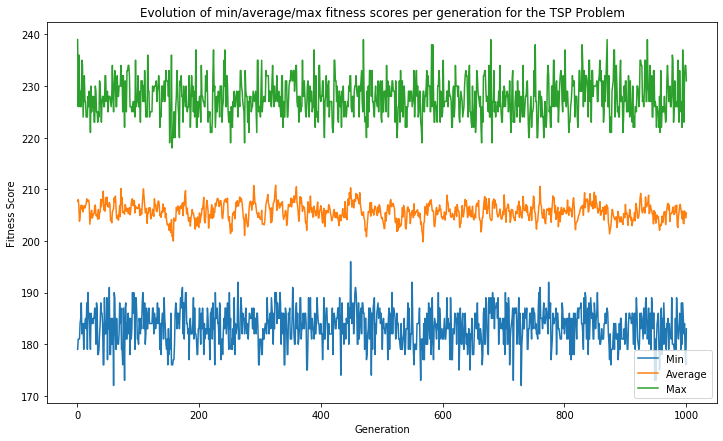

In [13]:
plt.hist(fitness_scores)

### Travelling salesman problem

In [74]:
class TSPProblem:
    def __init__(self, number_of_cities):
        '''Initiliaze the variables for the problem
        
            params:
                number_of_cities: define the number of cities in the problem
        '''
        #Initialise number of cities in the graph 
        self.number_of_cities = number_of_cities
        
        #Initialise nodes 
        self.nodes = np.arange(number_of_cities)
        
        #Define the representation
        self.representation = - np.ones((self.number_of_cities, self.number_of_cities));
        for i in range(number_of_cities):
            for j in range(number_of_cities):
                if i == j:
                    self.representation[i][j] = 0
                elif self.representation[j][i] != -1:
                    # Copy the value to have a symmetric matrix (as distance(0, 1) should be the same as distance(1, 0))
                    self.representation[i][j] = self.representation[j][i]
                else:
                    distance = np.random.choice(np.arange(10) + 1)
                    self.representation[i][j] = distance
        
    def get_representation(self):
        return self.representation
    
    def get_nodes(self):
        return self.nodes
    
    def get_distance(self,node1,node2):
        return self.representation[node1][node2]

In [75]:
############## TEST TEST TEST #################
TSPproblem1 = TSPProblem(5)
print(TSPproblem1.get_representation())
print(TSPproblem1.get_nodes())
print(TSPproblem1.get_distance(0,4))

[[ 0. 10.  4. 10.  8.]
 [10.  0.  8.  4. 10.]
 [ 4.  8.  0.  1.  8.]
 [10.  4.  1.  0.  7.]
 [ 8. 10.  8.  7.  0.]]
[0 1 2 3 4]
8.0


In [76]:
min_fit_KN = [np.min(item) for item in stats_Knapsack]
max_fit_KN = [np.max(item) for item in stats_Knapsack]
avg_fit_KN = [np.mean(item) for item in stats_Knapsack]

In [77]:
############## TEST TEST TEST #################
tsp_ind_example = TSPIndividual(TSPproblem1)
print(tsp_ind_example.get_phenotype())
print(tsp_ind_example.get_weight())
print(TSPproblem1.get_representation())
print(tsp_ind_example.get_fitness())
print(tsp_ind_example.get_problem())
print(tsp_ind_example.get_phenotype())

[1, 3, 4, 2]
33.0
[[ 0. 10.  4. 10.  8.]
 [10.  0.  8.  4. 10.]
 [ 4.  8.  0.  1.  8.]
 [10.  4.  1.  0.  7.]
 [ 8. 10.  8.  7.  0.]]
37.0
[1, 3, 4, 2]


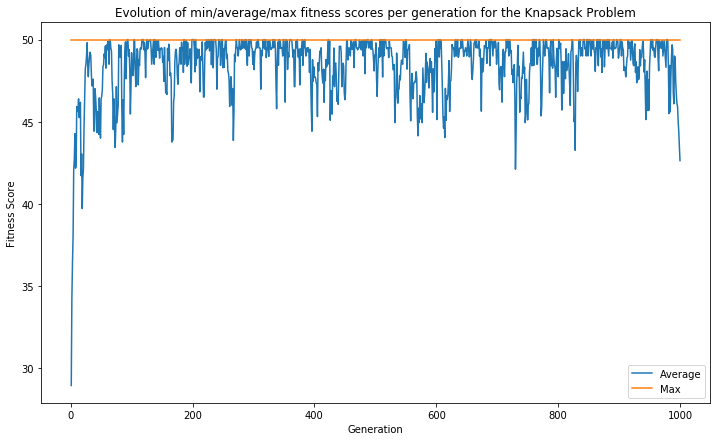

In [78]:
plt.figure(figsize = (12,7))
#plt.plot(np.arange(num_generation_runs) +1 , min_fit_KN)
plt.plot(np.arange(num_generation_runs) +1 , avg_fit_KN)
plt.plot(np.arange(num_generation_runs) +1 , max_fit_KN)
plt.ylabel("Fitness Score")
plt.xlabel("Generation")
plt.title("Evolution of min/average/max fitness scores per generation for the Knapsack Problem")
plt.legend([ "Average", "Max"])

In [83]:
##### TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST TEST
test1 = np.array(np.random.rand(10))

test = np.array(np.random.rand(10, 10))

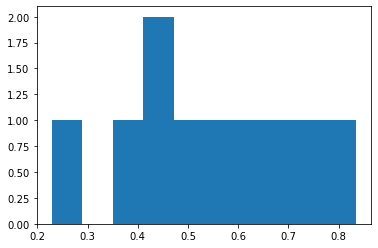

In [92]:
plt.ion()
fig = plt.figure()
plt.hist(test[0])
plt.show()

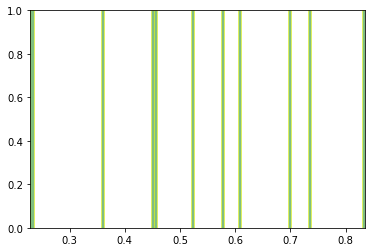

In [99]:
# NOTE: This doesn't seem to work ...


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation




# histogram our data with numpy
data = test
n, bins = np.histogram(data[0], 100)

# get the corners of the rectangles for the histogram
left = bins[:-1]
right = bins[1:]
bottom = np.zeros(len(left))
top = bottom + n
nrects = len(left)



nverts = nrects * (1 + 3 + 1)
verts = np.zeros((nverts, 2))
codes = np.full(nverts, path.Path.LINETO)
codes[0::5] = path.Path.MOVETO
codes[4::5] = path.Path.CLOSEPOLY
verts[0::5, 0] = left
verts[0::5, 1] = bottom
verts[1::5, 0] = left
verts[1::5, 1] = top
verts[2::5, 0] = right
verts[2::5, 1] = top
verts[3::5, 0] = right
verts[3::5, 1] = bottom



patch = None
def animate(i):
    # simulate new data coming in
    global data
    n, bins = np.histogram(data[i], 100)
    top = bottom + n
    verts[1::5, 1] = top
    verts[2::5, 1] = top
    return [patch, ]



fig, ax = plt.subplots()
barpath = path.Path(verts, codes)
patch = patches.PathPatch(
    barpath, facecolor='green', edgecolor='yellow', alpha=0.5)
ax.add_patch(patch)


ax.set_xlim(left[0], right[-1])
ax.set_ylim(bottom.min(), top.max())


ani = animation.FuncAnimation(fig, animate, 50, repeat=False, blit=True)
plt.show()

In [96]:
data = np.random.randn(1000)

(1000,)